<a href="https://colab.research.google.com/github/muvision/cm-mathvision/blob/main/OpenCV.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# OpenCV for MathVision

Installing opencv2, numpy, matplotlib, and sys.

In [17]:
from google.colab.patches import cv2_imshow
import cv2
import numpy as np
import matplotlib.pyplot as plt
import sys


Reading and displaying the starter image. Image resizing is temporary and only for displaying purposes.

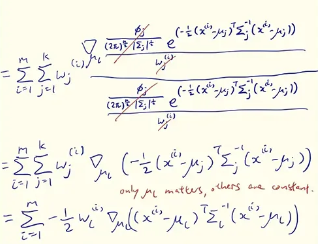

In [4]:
image = cv2.imread('/content/random.png')
cv2_imshow(image)


# TLDR
In order to calculate and crop the bounding boxes of the images, we first need apply a threshhold to an image. This essentially means that we are "binarizing the image". Here, any pixel color value lower than the threshold is set as 0, and any other is set as 1.

With the cv2.threshold(image, thresh-val, max-val, thresholding types) function this is achieved. Here is the breakdown our code:

1.   Image is converted to grayscale
2.   We apply a binary threshold and otsu threshold to the image
3.   We apply a dilation on the threshold image
4.   We create an inversion of the threshold image

## Full Breakdown

Upon converting the image to grayscale we apply a binary threshold and otsu threshold to the image. For the purposes of this portion of the project we need the binary conversion to be very strict, and with otsu binarization this is achieved.

![otsu.jpg](https://docs.opencv.org/3.4/otsu.jpg)

**What is otsu's binarization?**
In our original thresholding methods, we input a general threshold, and then use an arbitrary value as a threshold. With otsu's binarization, we **optimize that**, where instead of us choosing the threshold, otsu does it for us. The way this works is by choosing a threshold value for an image which only has two histogram peaks (see example image). The example also shows how using gaussian filtering optimizes the otsu work.

Note: When using the otsu binarization the passed in threshold values are arbitrary.

**Dilation**
Following these changes, we use dilation which is a basic morplogical operator used for "growing" the image.

We also create an inverted mask if the image, which is used in later parts.

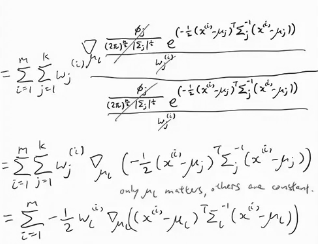

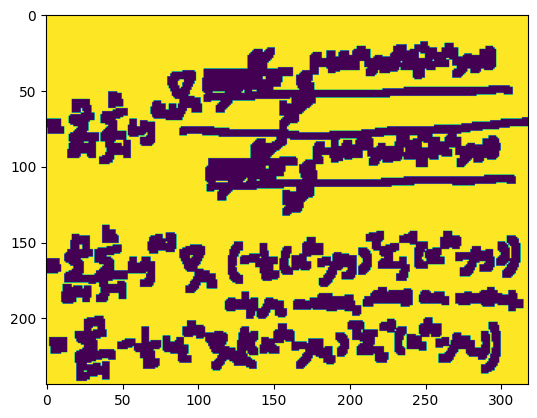

In [19]:
img_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
cv2_imshow(img_gray)

ret,thresh1=cv2.threshold(img_gray,0,255, cv2.THRESH_OTSU|cv2.THRESH_BINARY_INV)
rect_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5))
# Applying dilation on the threshold image
dilation = cv2.dilate(thresh1, rect_kernel, iterations = 1)
inverted_mask = cv2.bitwise_not(dilation)

plt.imshow(inverted_mask)

# Getting Contour Data
When we call for the contour and contour inverse data, we get an array of arrays containing x,y coordinates of contour points.

However, when .findContours is used, it detects only the darker color on a lighter foreground. If for example, the image was written in white writing on a black background, the contours data would be very small. Due to this, we compare the length of the contours data. Whichever has an array with more data points will be the contour data with actual information.

In [12]:
# Finding contours
contours, hierarchy = cv2.findContours(dilation, cv2.RETR_EXTERNAL,
                                                 cv2.CHAIN_APPROX_NONE)

# Finding contours inverse
contours_mask, hierarchy = cv2.findContours(inverted_mask, cv2.RETR_EXTERNAL,
                                                 cv2.CHAIN_APPROX_NONE)

if len(contours) > len(contours_mask):
  cntrs = contours
else:
  cntrs = contours_mask

# Bordered Images & Cropping

One problem we faced while writing this script was that images with a background to the main color would only get cropped once. For example, if you took a photo of text on a white sheet of paper, but the sheet of paper had a black background behind it, the contours would only return the borders of the white sheet.

To deal with this we wrote a while loop, which would run as long as the length of the contours array is <= 1, and a counter variable is less than 16 (to make sure that in case the image is alternating, we won't throw an error).

In this loop we use keep track of the max and minimum x values, and crop the sheet at these points. Then we find the contours again, and increment the counter. If after this we still see the contours to be <=1, we crop again.

In [13]:
# Creating a copy of image
im2 = image.copy()

max = [0,0,0,0]
min = [10000,10000,10000,10000]

cropped_image = im2
counter = 0
while len(cntrs) <=1 and counter <=16:
  for cnt in cntrs:
      x, y, w, h = cv2.boundingRect(cnt)

      if max[0] < x:
        max[0] = x
        max[1] = y
        max[2] = w
        max[3] = h

      if min[0] > x:
        min[0] = x
        min[1] = y
        min[2] = w
        min[3] = h

      # Drawing a rectangle on copied image
      # rect = cv2.rectangle(im2, (x, y), (x + w, y + h), (0, 255, 0), 2)

  cropped_image = im2[min[1]:max[1] + max[3], min[0]:max[0] + max[2]]
  dilation = dilation[min[1]:max[1] + max[3], min[0]:max[0] + max[2]]
  inverted_mask = inverted_mask[min[1]:max[1] + max[3], min[0]:max[0] + max[2]]

      # Finding contours
  contours, hierarchy = cv2.findContours(dilation, cv2.RETR_EXTERNAL,
                                                  cv2.CHAIN_APPROX_NONE)

  # Finding contours inverse
  contours_mask, hierarchy = cv2.findContours(inverted_mask, cv2.RETR_EXTERNAL,
                                                  cv2.CHAIN_APPROX_NONE)

  if len(contours) > len(contours_mask):
    cntrs = contours
  else:
    cntrs = contours_mask

  counter +=1

The following loop draws the green rectangles for each coordinate in contours.

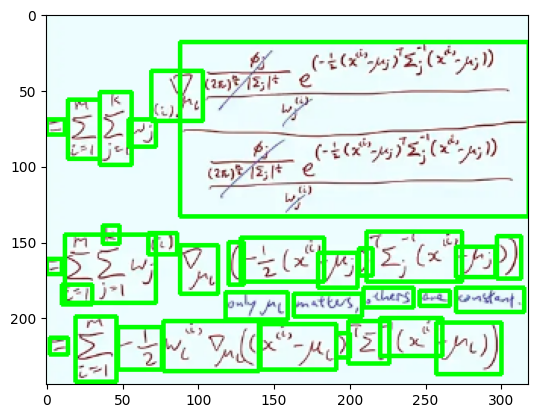

In [14]:
for cnt in cntrs:
    x, y, w, h = cv2.boundingRect(cnt)
    # print(f"{x},{y},{w},{h}")

    # Drawing a rectangle on copied image
    rect = cv2.rectangle(cropped_image, (x, y), (x + w, y + h), (0, 255, 0), 2)

plt.imshow(cropped_image)